In [1]:
import numpy as np
import pandas as pd
import argparse
# import h5py
import pdb
from keras.preprocessing import sequence
from keras.utils import pad_sequences
import keras
from keras import backend as K
from keras.models import load_model

import tensorflow as tf
from tensorflow import keras 
import datetime, os
from tensorboard import notebook

from tensorflow.keras import models 
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns


2023-01-03 12:12:47.953583: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-03 12:12:47.953649: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-03 12:12:49.039843: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-03 12:13:08.433592: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-03 12:13:08.433766: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

In [2]:
loaded_model = load_model('./../CNN_results_split_final/Final_model.model')
model = loaded_model

2023-01-03 12:13:37.500964: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-03 12:13:37.501066: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-03 12:13:37.501105: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (comp-sc-0237.acib.production.int.aci.ics.psu.edu): /proc/driver/nvidia/version does not exist


In [3]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2500)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 2500, 20)     520         ['input_2[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 2500, 20)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                           

                                                                                                  
 batch_normalization_7 (BatchNo  (None, 128)         512         ['dense_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 activation_1 (Activation)      (None, 128)          0           ['batch_normalization_1[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 128)          0           ['batch_normalization_7[0][0]']  
                                                                                                  
 dropout_1 (Dropout)            (None, 128)          0           ['activation_1[0][0]']           
                                                                                                  
 dropout_2

In [4]:
from keras.utils import pad_sequences


seq_rdic = ['A','I','L','V','F','W','Y','N','C','Q','M','S','T','D','E','R','H','K','G','P','O','U','X','B','Z']
seq_dic = {w: i+1 for i,w in enumerate(seq_rdic)}


def encodeSeq(seq, seq_dic):
    if pd.isnull(seq):
        return [0] 
    else:
        return [seq_dic[aa] for aa in seq]
    
    
def prot_feature_gen_from_str_input(prot_input_str, prot_len = 2500):
    Prot_ID = prot_input_str.split(':')[0]
    Prot_seq = prot_input_str.split(':')[1]
    prot_dataframe = pd.DataFrame({'Protein_ID': Prot_ID, 'Sequence': Prot_seq}, index = [0])
    prot_dataframe.set_index('Protein_ID')
    
    
    prot_dataframe["encoded_sequence"] = prot_dataframe.Sequence.map(lambda a: encodeSeq(a, seq_dic))
    prot_feature = pad_sequences(prot_dataframe["encoded_sequence"].values, prot_len)
    
    return prot_feature, Prot_ID
    
    
KEGG_compound_read = pd.read_csv('./../CNN_data/Final_test/kegg_compound.csv', index_col = 'Compound_ID')
kegg_df = KEGG_compound_read.reset_index()
    
def mol_feature_gen_from_str_input(mol_str, kegg_id_flag):
	
	if kegg_id_flag == 1:
		KEGG_ID = mol_str
		kegg_id_loc = kegg_df.index[kegg_df.Compound_ID == KEGG_ID][0]
		KEGG_ID_info = kegg_df.loc[kegg_id_loc]
		KEGG_ID_info_df = KEGG_ID_info.to_frame().T.set_index('Compound_ID')
		
		final_return = KEGG_ID_info_df
		final_id = KEGG_ID
		
	else: 
		try:
			mol_ID = mol_str.split(':')[0]
			mol_smiles = mol_str.split(':')[1]
			mol = Chem.MolFromSmiles(mol_smiles)
			fp1 = AllChem.GetMorganFingerprintAsBitVect(mol, useChirality=True, radius=2, nBits=2048)
			fp_list = list(np.array(fp1).astype(float))
			fp_str = list(map(str, fp_list))
			mol_fp = '\t'.join(fp_str) 
			
			mol_dict = {}
			mol_dict['Compound_ID'] = mol_ID
			mol_dict['Smiles'] = mol_smiles
			mol_dict['morgan_fp_r2'] = mol_fp
			
			mol_info_df = pd.DataFrame(mol_dict, index=[0])
			mol_info_df = mol_info_df.set_index('Compound_ID')
			
			final_return = mol_info_df
			final_id = mol_ID
			
		except Exception as error:
			print('Something wrong with molecule input string...' + repr(error)) 
			
	return final_return, final_id
    
    
def act_df_gen_mol_feature(mol_id, prot_id):
	act_df = pd.DataFrame({'Protein_ID':prot_id, 'Compound_ID': mol_id}, index = [0])
	
	return act_df


def load_modelfile(model_string):
	loaded_model = tf.keras.models.load_model(model_string)
	return loaded_model


def model_prediction(compound_feature, enz_feature):
    prediction_vals = loaded_model.predict([compound_feature, enz_feature])
    
    return prediction_vals[0][0]


def compound_feature_gen_df_input(act_df, comp_df, comp_len = 2048, comp_vec= 'morgan_fp_r2'):
    act_df = pd.merge(act_df, comp_df, left_on='Compound_ID', right_index = True)
    comp_feature = np.stack(act_df[comp_vec].map(lambda fp: fp.split("\t")))
    comp_feature = comp_feature.astype('float')
    return comp_feature
    
def protein_feature_gen(prot_csv_file, prot_len = 2500):
    protein_df = pd.read_csv(prot_csv_file, index_col='Protein_ID')
    protein_df["encoded_sequence"] = protein_df.Sequence.map(lambda a: encodeSeq(a, seq_dic))
    pfeature = pad_sequences(protein_df["encoded_sequence"].values, prot_len)
    
    return pfeature, protein_df


def compound_feature_gen(act_csv_file, comp_csv_file, comp_len = 2048, comp_vec = 'morgan_fp_r2'):
    act_df = pd.read_csv(act_csv_file)
    comp_df = pd.read_csv(comp_csv_file, index_col = 'Compound_ID')
    act_df = pd.merge(act_df, comp_df, left_on='Compound_ID', right_index = True)
    comp_feature = np.stack(act_df[comp_vec].map(lambda fp: fp.split("\t")))
    comp_feature = comp_feature.astype('float')
    return comp_feature, act_df

In [5]:
def grad_cam(layer_name, data):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    last_conv_layer_output, preds = grad_model(data)

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(data)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0))

    last_conv_layer_output = last_conv_layer_output[0]

    heatmap = last_conv_layer_output * pooled_grads
    
    return heatmap



## Rule 1 top candidate feature generation


In [6]:
pstr = "A0A7T5EPK7:MKYFSAAVIPGDGIGPEVMEVGMSLLQAIGDIHGGLSFEAESFPWNCRYYLQHGRMMPEDGLERLRPFDVILLGAIGAPGVPDHISVWELILPIRRSFQQYVNLRPIKLLRGLESPLRGKGHEHLDFVVVRENTEGEYSNMGGRLHVGTPYEMAMQNNVFTRYGTERIIRYAFELAQATGKTRLTAATKSNGINHSMPFWDEIVKEISLHYPNIQTSLIHIDALAAFFVSRPEAFDVVVASNLFGDILTDLGAAVVGGLGLAPSGNINPEKTYPSMFEPIHGSAPDIAGRGIANPIATIWSISMMLDHLGERELGRLVLDCIEEVLVEGKVRTPDIGGKATTQEMGKAILAQLYRRGG"
cstr = 'C00497'

pf, pid = prot_feature_gen_from_str_input(pstr)
cf, cid = mol_feature_gen_from_str_input(cstr, 1)
act_dataframe = act_df_gen_mol_feature(cid, pid)

cfeat = compound_feature_gen_df_input(act_dataframe, cf)

In [7]:
loaded_model.predict([cfeat, pf])

1/1 [==============================] - 3s 3s/step


array([[0.9979187]], dtype=float32)

## Rule 2 top candidate feature generation 

In [8]:
pstr_r2 = "A0A1D8PAW7:MKRILVAGGAGFIGSHLCERLVNEGHYVVCLDNFFTGNKKKVEQLLNNPRFEIAKHDVIEPYFNEVDEIYNLACPASPIHYQVDPIKTIKTSVLGAMNMLGLAKKTNAKILQASTSEVYGEPEVHPQYEEYWGNVNPIGKRSCYNEGKRCAESLFINYHSQHQTKIKIIRIFNTYGPKMDINDGRVISNFVIQALKGKDITIYGDGKQTRSFQYVDDLVEGMIRMMNTDDSFTGPVNIGNPEEYTMLELVSFIIEMTQSKSKLIFLPLPEDDPKRRRPNIELAKKELNNWEPKIKLREGLIKTINYFEKII"
cstr_r2 = 'C00149'

pf_r2, pid_r2 = prot_feature_gen_from_str_input(pstr_r2)
cf_r2, cid_r2 = mol_feature_gen_from_str_input(cstr_r2, 1)
act_dataframe_r2 = act_df_gen_mol_feature(cid_r2, pid_r2)

cfeat_r2 = compound_feature_gen_df_input(act_dataframe_r2, cf_r2)


In [9]:
loaded_model.predict([cfeat_r2, pf_r2])

1/1 [==============================] - 0s 42ms/step


array([[0.996195]], dtype=float32)

In [10]:
def CAM_Res(cfeature, pfeature):
    data_pair = [cfeature, pfeature]
    nzero_idx = np.nonzero(pfeature[0])[0]
    
    conv1d_gcam_out = grad_cam('conv1d', data_pair)
    conv1d_gcam_out1 = grad_cam('conv1d_1', data_pair)
    conv1d_gcam_out2 = grad_cam('conv1d_2', data_pair)
    conv1d_gcam_out3 = grad_cam('conv1d_3', data_pair)
    conv1d_gcam_out4 = grad_cam('conv1d_4', data_pair)
    
    c_v = np.max(conv1d_gcam_out, axis = 1)
    c_v1 = np.max(conv1d_gcam_out1, axis = 1)
    c_v2 = np.max(conv1d_gcam_out2, axis = 1)
    c_v3 = np.max(conv1d_gcam_out3, axis = 1)
    c_v4 = np.max(conv1d_gcam_out4, axis = 1)
    
    cvseq = c_v[nzero_idx]
    cvseq1 = c_v1[nzero_idx]
    cvseq2 = c_v2[nzero_idx]
    cvseq3 = c_v3[nzero_idx]
    cvseq4 = c_v4[nzero_idx]
    
    
    relu_cv = []
    relu_cv1 = []
    relu_cv2 = []
    relu_cv3 = []
    relu_cv4 = []
    
    for i in cvseq:
        if i<= 0:
            val = 0
        else:
            val = i
        relu_cv.append(val)
    
    for i in cvseq1:
        if i<= 0:
            val1 = 0
        else:
            val1 = i
        relu_cv1.append(val1)
    
    for i in cvseq2:
        if i<= 0:
            val2 = 0
        else:
            val2 = i
        relu_cv2.append(val2)
    
    for i in cvseq3:
        if i<= 0:
            val3 = 0
        else:
            val3 = i
        relu_cv3.append(val3)
    
    for i in cvseq4:
        if i<= 0:
            val4 = 0
        else:
            val4 = i
        relu_cv4.append(val4)
        
    relu_cv_ar = np.array(relu_cv)
    relu_cv_ar1 = np.array(relu_cv1)
    relu_cv_ar2 = np.array(relu_cv2)
    relu_cv_ar3 = np.array(relu_cv3)
    relu_cv_ar4 = np.array(relu_cv4)
    
    relu_cv_norm = relu_cv_ar/np.max(relu_cv_ar)
    relu_cv_norm1 = relu_cv_ar1/np.max(relu_cv_ar1)
    relu_cv_norm2 = relu_cv_ar2/np.max(relu_cv_ar2)
    relu_cv_norm3 = relu_cv_ar3/np.max(relu_cv_ar3)
    relu_cv_norm4 = relu_cv_ar4/np.max(relu_cv_ar4)
    
    all_cv_ar = np.transpose(np.stack([relu_cv_ar, relu_cv_ar1,relu_cv_ar2,relu_cv_ar3,relu_cv_ar4]))
    
    all_CAM = np.transpose(np.stack([relu_cv_norm, relu_cv_norm1, relu_cv_norm2, relu_cv_norm3, relu_cv_norm4]))
    
    
    
    return all_CAM, all_cv_ar

In [11]:
a_r1, acv_r1  = CAM_Res(cfeat, pf)
a_r2, acv_r2 = CAM_Res(cfeat_r2, pf_r2)

In [12]:
all_av = np.sum(acv_r1,axis=1)/5
all_av_r2 = np.sum(acv_r2, axis=1)/5

In [13]:
all_av_norm = all_av/np.max(all_av)
all_av_norm2 = all_av_r2/np.max(all_av_r2)

In [14]:
bsite_r1 = pd.read_csv('Rule_1_binding.csv')
bsite_r2 = pd.read_csv('Rule_2_binding.csv')


bsite_r1_ls = bsite_r1['cam'].tolist()
bsite_r2_ls = bsite_r2['cam'].tolist()

bs_loc_r1 = np.nonzero(np.array(bsite_r1_ls))
bs_loc_r2 = np.nonzero(np.array(bsite_r2_ls))

## Residue level CAM scores for Rule R1

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

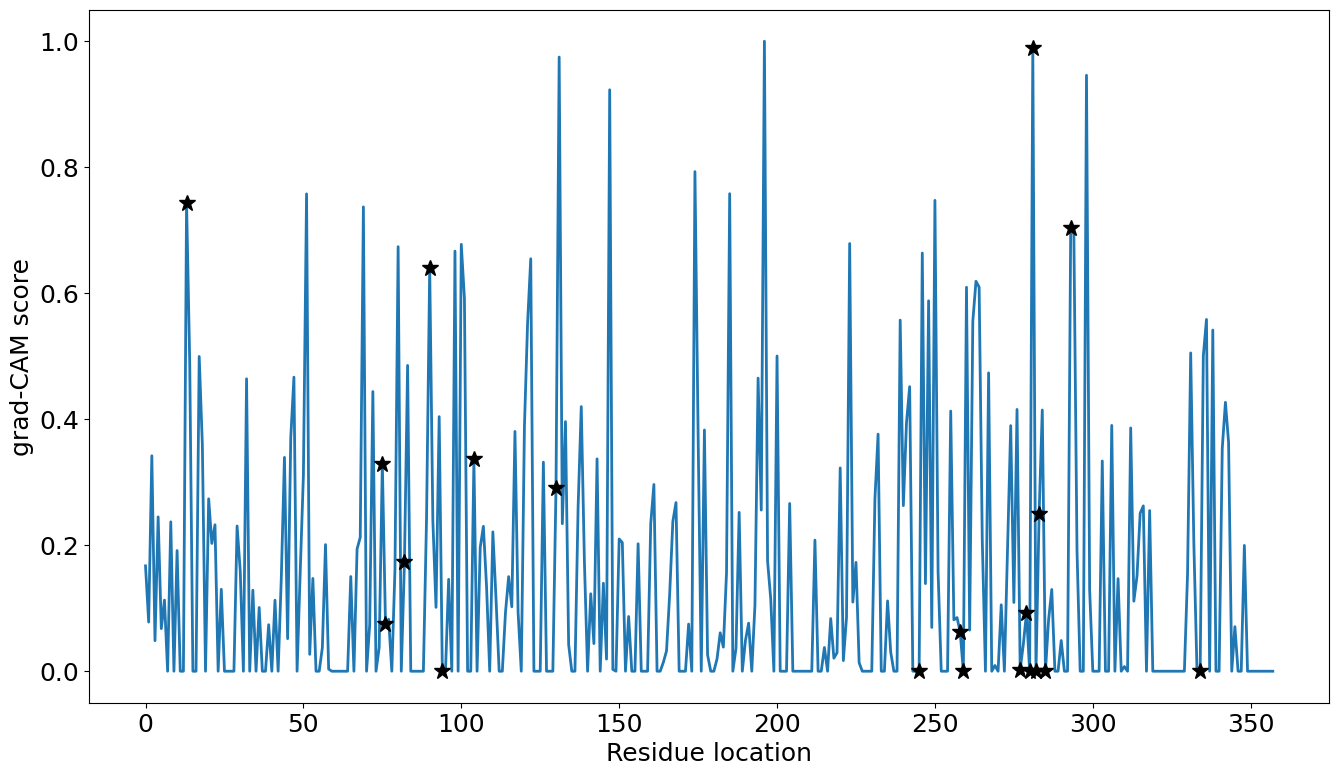

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,9), )
plt.plot(all_av_norm, linewidth = 2)
plt.plot(bs_loc_r1,[all_av_norm[i] for i in bs_loc_r1], marker="*", color='k', markersize = 12)
plt.xlabel('Residue location', fontsize = 18)
plt.ylabel('grad-CAM score', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

plt.savefig('rule_1_CAM_fig.png')

## Residue level CAM scores for Rule R2

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

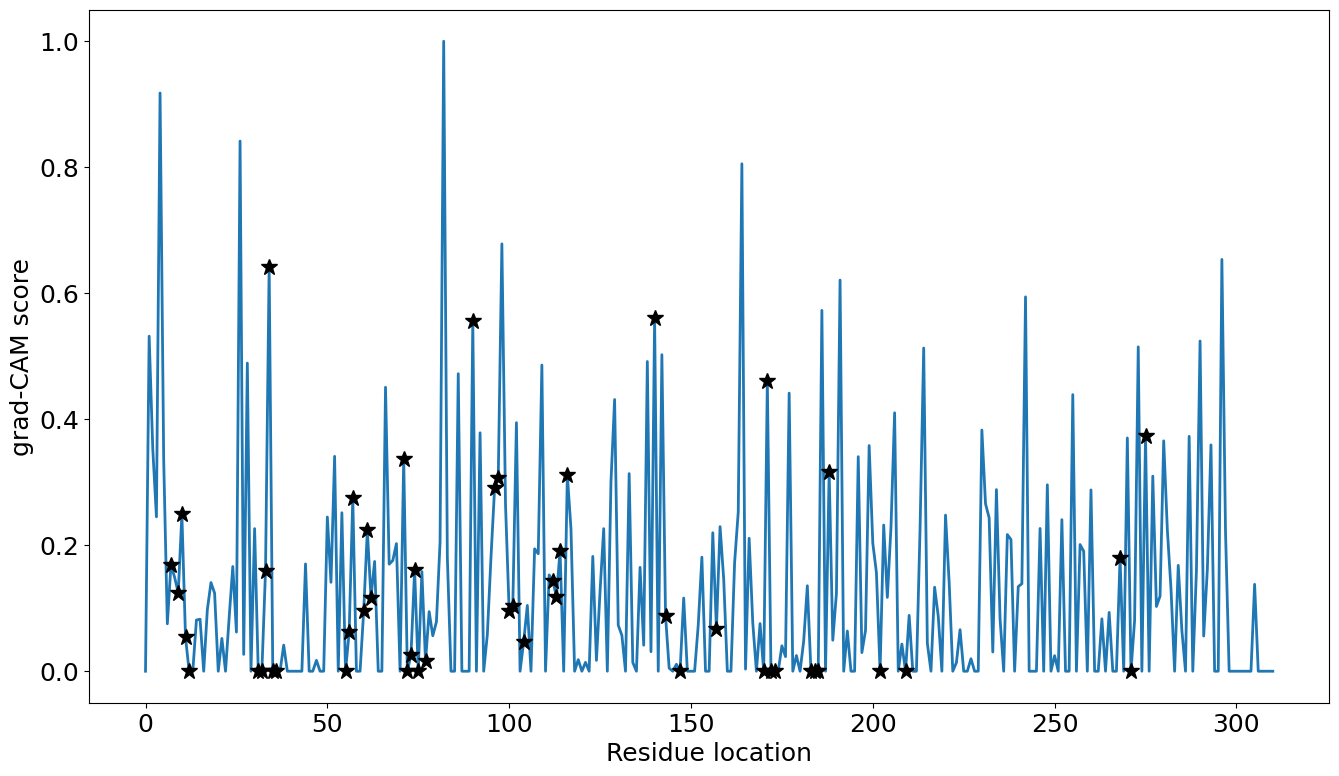

In [16]:
plt.figure(figsize=(16,9))
plt.plot(all_av_norm2, linewidth = 2)
plt.plot(bs_loc_r2,[all_av_norm2[i] for i in bs_loc_r2], marker="*", color='k', markersize = 12)
plt.xlabel('Residue location', fontsize = 18)
plt.ylabel('grad-CAM score', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.savefig('rule_2_CAM.png')